# Tarea: Conectividad de acuerdo a señales de EEG
## Tópicos selectos de Ciencia de Datos
### Luis David Huante

## Código: Trabajo en clase

In [ ]:
!pip install mne

In [ ]:
import numpy as np
import mne
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

Leemos el archivo `h01.edf`

In [ ]:
h01 = mne.io.read_raw_edf('h01.edf')

Extracting EDF parameters from /content/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-9512a048165d>:1: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  h01 = mne.io.read_raw_edf('h01.edf')


Obtenemos los nombres de los canales

In [ ]:
h01.ch_names

['Fp2',
 'F8',
 'T4',
 'T6',
 'O2',
 'Fp1',
 'F7',
 'T3',
 'T5',
 'O1',
 'F4',
 'C4',
 'P4',
 'F3',
 'C3',
 'P3',
 'Fz',
 'Cz',
 'Pz']

Obtenemos información del archivo

In [ ]:
h01.info

Measurement date,"June 23, 2003 16:14:37 GMT"
Experimenter,Unknown
Participant,DJZ
Digitized points,Not available
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


Graficamos los valores correspondientes a cada canal del archivo

Using matplotlib as 2D backend.


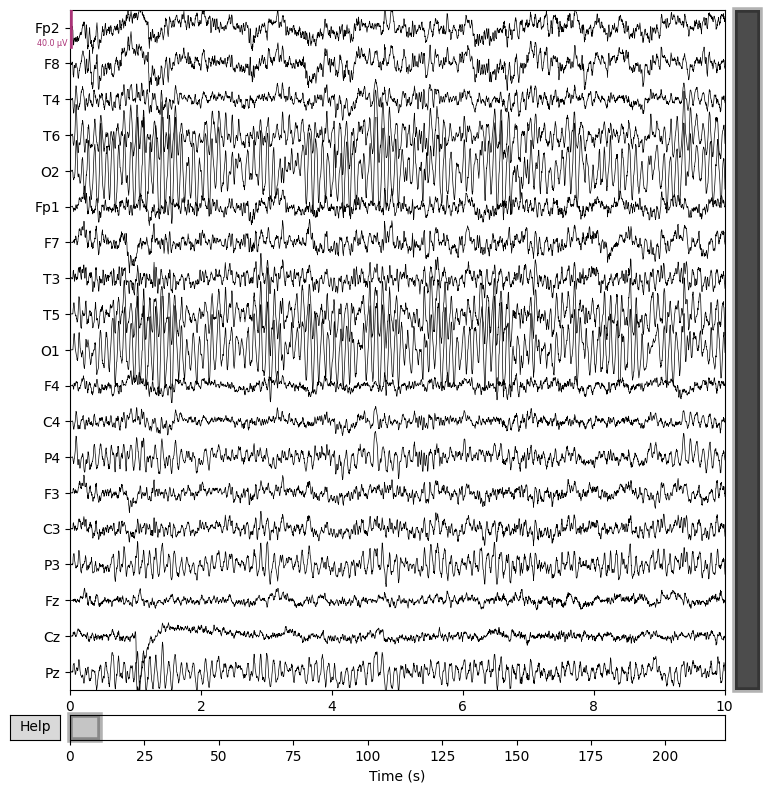

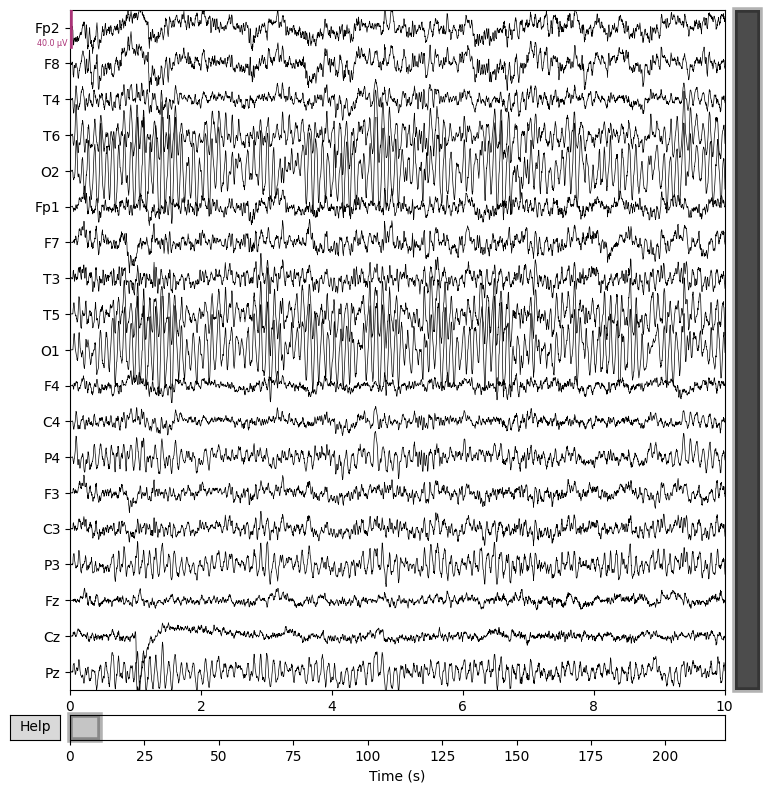

In [ ]:
h01.plot()

Asignamos el nombre de los canales a una ubicación de sensores craneales

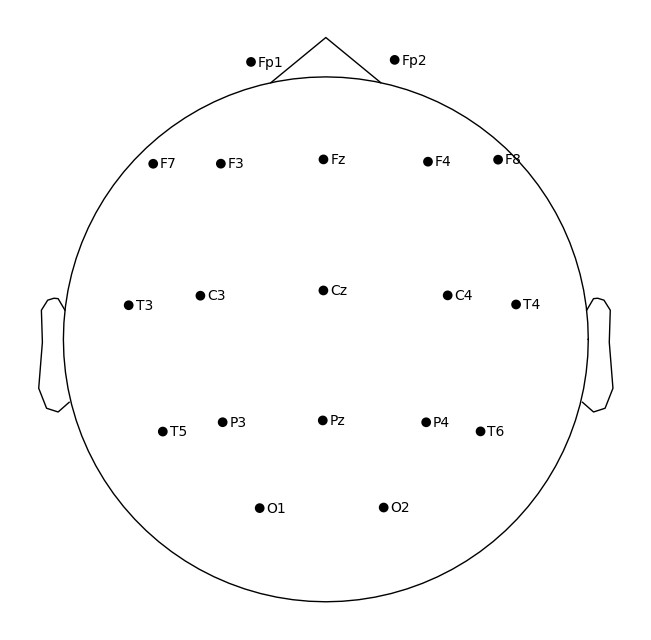

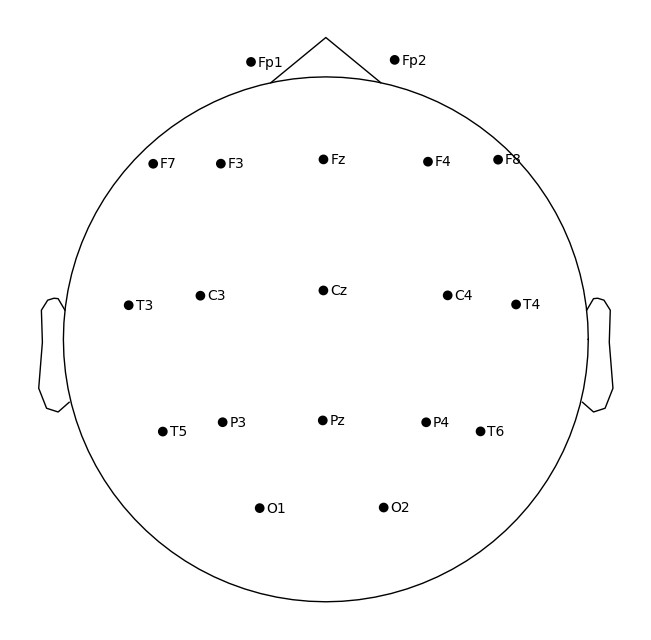

In [ ]:
h01.set_montage('standard_1005')
h01.plot_sensors(show_names=True)

Asignamos los datos del archivo a la variable H

In [ ]:
H = h01.get_data()

In [ ]:
H.shape

(19, 55000)

Importamos mutual_info_regression

In [ ]:
from sklearn.feature_selection import mutual_info_regression

In [ ]:
mutual_info_regression(H.T, H[0,:])

array([5.83867435, 0.22427465, 0.06005737, 0.02523852, 0.02463679,
       0.3273903 , 0.11476948, 0.02313156, 0.0212235 , 0.02625813,
       0.15788165, 0.03696321, 0.02307115, 0.09089225, 0.01603113,
       0.02375889, 0.1508538 , 0.0189891 , 0.03788096])

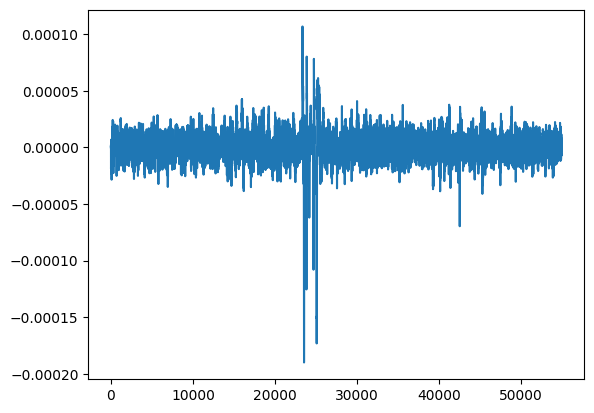

In [ ]:
plt.plot(H[0,:])

Descargamos la matriz del archivo h01_nmi.txt

In [ ]:
A1 = np.loadtxt('h01_nmi.txt')

Observamos sus características

In [ ]:
A1.shape

(19, 19)

Graficamos sus valores como imagen

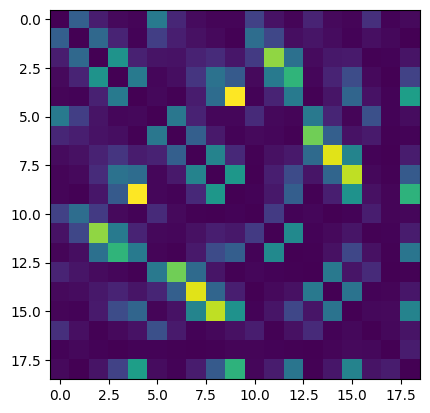

In [ ]:
plt.imshow(A1)

In [ ]:
LT_A1 = np.tril(A1)
LT_A1.shape

(19, 19)

Cambiamos la forma de la matriz y quedamos con un vector de 361 entradas


In [ ]:
Reshaped_A1 = np.reshape(LT_A1, 361)
Reshaped_A1

Graficamos

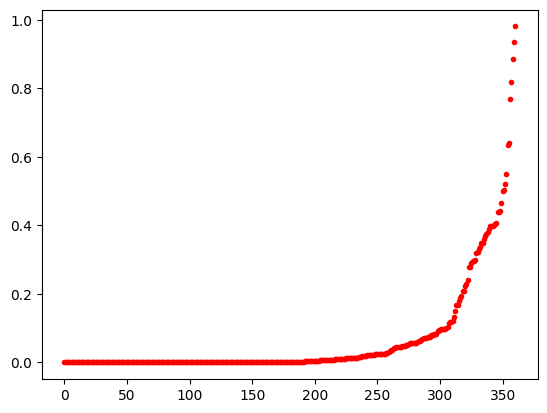

In [ ]:
plt.plot(sorted(Reshaped_A1), '.r')

Graficamos ahora sólo los valores que superan el `threshold` de 0.2

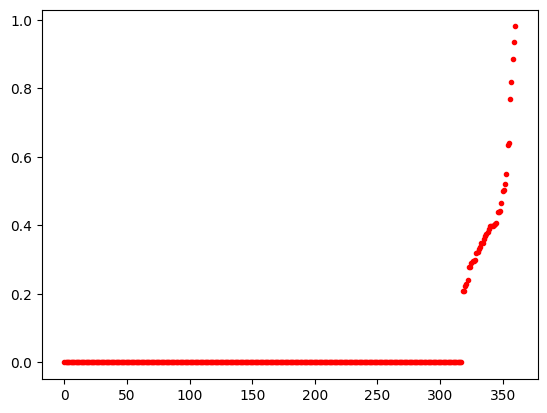

In [ ]:
threshold = 0.2
Reshaped_A1[Reshaped_A1 < threshold ] = 0
plt.plot(sorted(Reshaped_A1), '.r')

Creamos un grafo con los valores que sean mayores al treshold

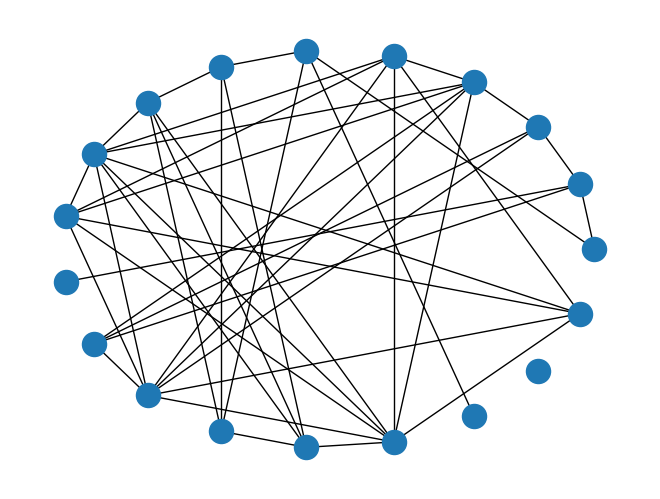

In [ ]:
# Mantenemos los valores mayores a 0.2
A1[A1 < threshold ] = 0

#Creamos el grafo
G = nx.from_numpy_array(A1)
nx.draw_circular(G)

## Tarea: Clasificador

Considerando el conjunto de señales que se muestra en el dataset(Encefalograma), construir un clasificador que distinga entre personas sanas y personas con esquizofrenia, basado en patrones de conectividad. Para ello:
1. Construir una red para cada paciente.
2. Construir una representación vectorial para cada red.
3. Construir el clasificador

In [ ]:
# Etiquetas
y = ['h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h',
    's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's']

# Convertimos las etiquetas a formato numérico (0 para 'h', 1 para 's')
label_mapping = {'h': 0, 's': 1}
y_numeric = np.array([label_mapping[label] for label in y])

In [ ]:
# Creamos una lista con los nombres de los archivos
connectivity_files = [f"h{i:02}_nmi.txt" for i in range(1, 15)] + [f"s{i:02}_nmi.txt" for i in range(1, 15)]

In [ ]:
# Lista para almacenar los vectores de características
feature_vectors = []

# Definimos el treshold
treshold = 0.2

# Iteramos sobre cada archivo
for file_path in connectivity_files:
    connectivity_matrix = np.loadtxt(file_path)

    # Aplicamos el umbral
    thresholded_matrix = np.where(connectivity_matrix > threshold, connectivity_matrix, 0)

    # Creamos la red
    G = nx.from_numpy_array(thresholded_matrix)

    # Calculamos las características de la red
    features = {}
    features['average_clustering'] = nx.average_clustering(G)
    # Encontramos la componente conectada más grande y calcularmos la longitud del camino más corto solo para esa componente
    if nx.is_connected(G):
        features['average_shortest_path_length'] = nx.average_shortest_path_length(G)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        features['average_shortest_path_length'] = nx.average_shortest_path_length(subgraph)

    feature_vector = np.array(list(features.values()))
    feature_vectors.append(feature_vector)

# Creamos el vector de características
X = np.array(feature_vectors)

In [ ]:
# Métodos
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.3, random_state=42)

# Entrenamos el clasificador
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Evaluamos el clasificador
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.67      0.50      0.57         4

    accuracy                           0.67         9
   macro avg       0.67      0.65      0.65         9
weighted avg       0.67      0.67      0.66         9



In [ ]:
from sklearn.model_selection import cross_val_score

# Validación cruzada
clf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(clf, X, y_numeric, cv=5)
print("Scores en cada fold: ", scores)

Scores en cada fold:  [0.66666667 1.         0.66666667 0.6        0.8       ]
